# Law, Bias, and Algorithms
## Included variable bias (2/2)

In [2]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Read the data
stop_df <- read_rds("../data/sqf_sample.rds")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


## Included variable bias

As we discussed last time, one common method for measuring disparities while addressing some of the omitted variable bias concerns is to include _all_ recorded data, that would have been available to the officer at the time of making the decision (to frisk an individual). This is also known as the "kitchen sink" approach.

In [3]:
# Use race_coefs(m) to inspect just the race coefficients of any fitted model m
race_coefs <- function(m) {
    coef(m)[c("suspect_raceblack", "suspect_racehispanic")]
}

feats <- c(
    "suspected_crime",
    "precinct",
    "location_housing",
    "suspect_sex",
    "suspect_age",
    "suspect_height",
    "suspect_weight",
    "suspect_hair",
    "suspect_eye",
    "suspect_build",
    "additional_report",
    "additional_investigation",
    "additional_proximity",
    "additional_evasive",
    "additional_associating",
    "additional_direction",
    "additional_highcrime",
    "additional_time",
    "additional_sights",
    "additional_other",
    "stop_reason_object",
    "stop_reason_desc",
    "stop_reason_casing",
    "stop_reason_lookout",
    "stop_reason_clothing",
    "stop_reason_drugs",
    "stop_reason_furtive",
    "stop_reason_violent",
    "stop_reason_bulge",
    "stop_reason_other",
    "suspect_race"
)

# This creates a formula with a specified left-hand side (frisked), and using 
# all the variables in feats on the right-hand side. 
# Constructing a formula in this way (instead of typing out all the variable names)
# is helpful for constructing multiple models that share a long list of variables in the right-hand side.
kitchen_sink_formula <- reformulate(feats, response = "frisked")

# We are only interested in the race coefficients
ks_model <- glm(kitchen_sink_formula, stop_df, family = binomial)
print(race_coefs(ks_model))

   suspect_raceblack suspect_racehispanic 
               0.191                0.173 


The problems with including variables in measuring disparate impact is that the correlation between a feature and race itself is not necessarily justified.
An obvious example would be something like "skin color", where including skin color in the regression will likely account for observed disparities in race,
but the correlation between skin color and race is unlikely to be justified!
On the other hand, a less obvious example would be an officers suspicion of `cpw`.
While it seems reasonable that an officer would frisk individuals suspected of posessing a weapon more frequently,
the suspicion itself would only be justified if, and to the degree that, it is predictive of achieving the goal of a frisk: recovering weapons.

Blindly including a variable in the regression for treatment fails to take into account this _degree_ of justification, 
often overcompensating for variables that are correlated with race.
This is the problem known as _included variable bias_.

## Risk-adjusted regression

As we briefly discussed, adjusting for any variable (i.e., including it in the regression) is only justified if, and to the degree that, the variable is _predictive of the outcome we are ultimately interested in_ (in this case, recovering a weapon). But the extent to which each variable is justified is rarely clear.

One simple idea for addressing this concern of included variable bias is to control for an explicit measure of **risk**, instead of controling for invididual variables.
Intuitively, we wish to know whether individuals who have _similar risk_ (of carrying a weapon) were treated (frisked) equally.

### Exercise 1: Estimating risk

In order to adjust for risk, we must first estimate it. This is relatively straight forward in the context of frisk decisions in stop-and-frisk, 
because the goal of a frisk is clear---we wish to recover weapons. 
In other words, we want to predict whether a weapon would be found if an individual is frisked. 

* **Step 1**: `filter` the `stop_df` data to those individuals _who were frisked_. We will call this new data frame `frisked_df`

The _risk_ that we are interested in estimating is the probability that a weapon is recovered given that we _frisk_ someone who has already been stopped.
While there are many ways to achieve this, one simple way is to build a predictive model, predicted the probability that a weapon is recovered, 
using just the data for stopped individuals who happened to be frisked.

In [4]:
# Subset the stop_df data to train cases where the individual was frisked
# WRITE CODE HERE
# START solution
frisked_df <- stop_df %>%
    filter(frisked)
# END solution

* **Step 2**: Using the `frisked_df` data, fit a logistic regression model to predict whether or not a weapon is found using all features that would reasonably be available to an officer (as listed in `feats` above). Let's call this model `risk_model`. 

Note that we use logistic regression here for simplicity, but in reality, more complex methods for predictive modeling could be employed, with additional measures to avoid overfitting (such as splitting the data and regularizing).

In [5]:
# Using the subset of data from Step 2, fit the logistic regression model: found_weapon ~ (all legitimate features in feats) 
# WRITE CODE HERE
# START solution
risk_formula <- reformulate(feats, response = "found_weapon")
risk_model <- glm(risk_formula, data = frisked_df, family = binomial)
# END solution

* **Step 3**: Use the `risk_model` from above to generate a column of model estimated risk (we'll name this column `risk`) on the original `stop_df` data. 

_Tip_: Given a `glm` model named `risk_model`, a vector of probability predictions for `stop_df` can be created with the command `predict(risk_model, stop_df, type = "response")`.

In [6]:
# Generate a column of predicted risk 
# WRITE CODE HERE
# START solution
stop_df <- stop_df %>%
    mutate(risk = predict(risk_model, ., type = "response"))
# END solution

## Distribution of risk

Now that we have an estimate of risk, we can explore the distribution of risk across race groups.

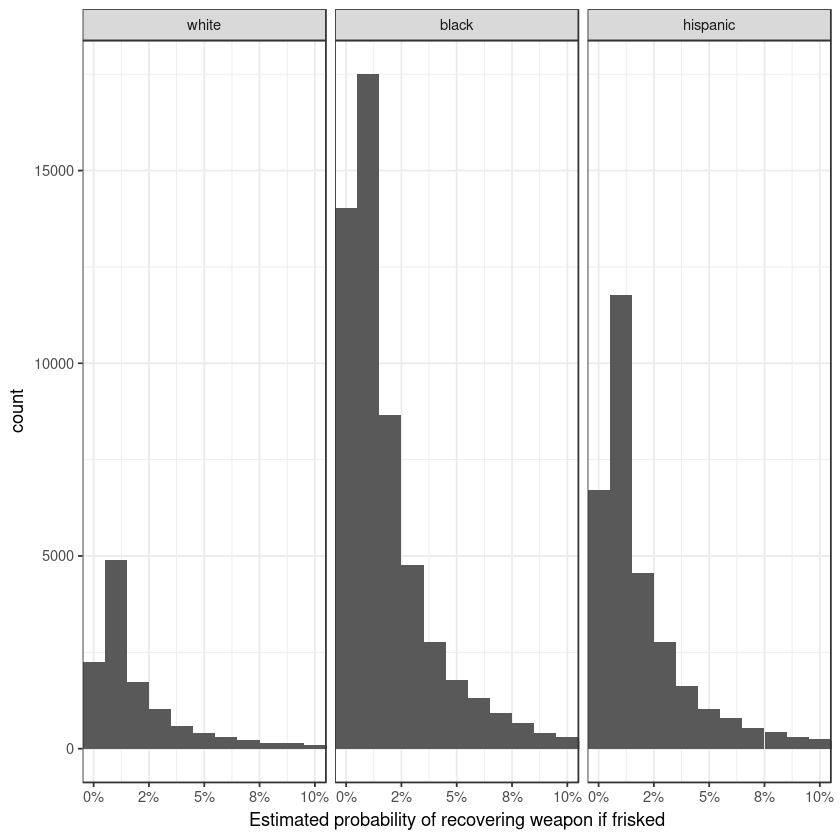

In [7]:
ggplot(stop_df, aes(x = risk)) +
geom_histogram(binwidth = .01) +
facet_wrap(~ suspect_race) +
scale_x_continuous("Estimated probability of recovering weapon if frisked",
                   labels = scales::percent_format(1)) +
coord_cartesian(xlim = c(0, .1))

### Exercise 2: Frisk rates by estimated risk

Given risk estimates, consider individuals who have estimated risk between 4% and 5%. 
For each race group within this range of risk, compute the (1) the number stops and (2) rate of frisk.

Try exploring different ranges of risk. It might be helpful to refer to the histogram above to see roughly how many cases exist for each race group, within each range of estimated risk.
Discuss your findings with your partner. What are some implecations of these findings?

In [8]:
# WRITE CODE HERE
# START solution
stop_df %>%
    filter(risk >= .04, risk <= .05) %>%
    group_by(suspect_race) %>%
    summarize(N = n(),
              p_frisk = mean(frisked))
# END solution

suspect_race,N,p_frisk
white,476,0.532
black,2185,0.834
hispanic,1258,0.781


### Exercise 3: Risk-adjusted regression

Now compute disparate impact of the decision to frisk stopped individuals across different race groups, adjusting for (estimated) risk.

How do these results compare to both the naive baserates and the "kitchen sink" approach?

In [9]:
# WRITE CODE HERE
# START solution
rar_model <- glm(frisked ~ suspect_race + risk, stop_df, family = binomial)
print(summary(rar_model))
# END solution


Call:
glm(formula = frisked ~ suspect_race + risk, family = binomial, 
    data = stop_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.253  -1.294   0.783   0.811   1.116  

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)            0.1436     0.0189    7.59  3.2e-14 ***
suspect_raceblack      0.7891     0.0206   38.23  < 2e-16 ***
suspect_racehispanic   0.6599     0.0220   30.03  < 2e-16 ***
risk                   5.0839     0.2012   25.27  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 120059  on 99999  degrees of freedom
Residual deviance: 117842  on 99996  degrees of freedom
AIC: 117850

Number of Fisher Scoring iterations: 4



### Exercise 4: Additional considerations

Even after adjusting for risk, disparities across certain features may still be justified.
For example, officers might enforce different standards for different location types: frisking individuals stopped in `transit` who they would not have frisked
if found in `housing`.  

Given the risk-adjusted regression results, what may be some other legitimate concerns? 
What are possible justifications for the racial disparities that persist after adjusting for risk? 
How could we revise our model to further account for such possibilities.

In [10]:
# WRITE CODE HERE
# START solution
rar_model <- glm(frisked ~ suspect_race + risk + location_housing, stop_df, family = binomial)
print(summary(rar_model))
# END solution


Call:
glm(formula = frisked ~ suspect_race + risk + location_housing, 
    family = binomial, data = stop_df)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.433  -1.283   0.744   0.801   1.403  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)               0.4875     0.0352    13.8   <2e-16 ***
suspect_raceblack         0.8394     0.0210    40.0   <2e-16 ***
suspect_racehispanic      0.7013     0.0222    31.6   <2e-16 ***
risk                      5.6908     0.1989    28.6   <2e-16 ***
location_housingneither  -0.3108     0.0305   -10.2   <2e-16 ***
location_housingtransit  -1.0178     0.0342   -29.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 120059  on 99999  degrees of freedom
Residual deviance: 116351  on 99994  degrees of freedom
AIC: 116363

Number of Fisher Scoring iterations: 4

